In [1]:
import ProtobufTypes_pb2 
import pandas as pd
import sys
from google.protobuf.json_format import MessageToDict
import collections
import numpy as np
import glob
import seaborn as sns
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
import pprint
from IPython.display import display
from datetime import date
# rcParams.keys()

In [2]:
PROCESSED_DATA_PATH = '../ProcessedData'
PLOT_PATH = f'./PLOTS-{date.today().strftime("%b-%d-%Y")}/fixations_grasps/'

os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

sns.set(context = "talk", style="white", palette="deep", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':15, 'font.sans-serif':'DejaVu Sans'})

In [3]:
objs_dict = {'Other':0, 'Cube_Blue': 1, 'Cube_Green':2, 'Cube_Red':3, 'Cube_Yellow':4, 'Cylinder_Blue':5,
             'Cylinder_Green':6, 'Cylinder_Red':7, 'Cylinder_Yellow':8, 'Sphere_Blue':9, 'Sphere_Green':10,
             'Sphere_Red':11, 'Sphere_Yellow':12, 'Tetraeder_Blue':13, 'Tetraeder_Green':14,
             'Tetraeder_Red':15, 'Tetraeder_Yellow':16}

In [5]:
samples_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/03_ET_samples_withGraspOnset.csv', index_col=False)

c:\users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
def replace_objs(s):
    valid_objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 'Cylinder_Blue', 'Cylinder_Green',
                  'Cylinder_Red','Cylinder_Yellow', 'Sphere_Blue', 'Sphere_Green', 'Sphere_Red',
                  'Sphere_Yellow', 'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']
    if s in valid_objs:
        return s
    else:
        return 'Other'

samples_df.handData_graspedObject = samples_df.handData_graspedObject.apply(replace_objs)
samples_df.combinedEye_raycastHitObject = samples_df.combinedEye_raycastHitObject.apply(replace_objs)


In [71]:
(samples_df
 .query('timestamp == grasp_onset and grasp_duration !=0 ')
#  .groupby('trialID')
 .grasp_onset
 .count()
)

20603

,subjectID,subjectfileName,trialID,trialNum,TrialDuration
0,2006,../experiment_et_data\subject2006.etd,0.0,0,50.566628
1,2006,../experiment_et_data\subject2006.etd,0.0,3,52.734188
2,2006,../experiment_et_data\subject2006.etd,0.0,18,50.777177
3,2006,../experiment_et_data\subject2006.etd,1.0,5,70.388352
4,2006,../experiment_et_data\subject2006.etd,1.0,13,55.032552
...,...,...,...,...,...
1409,2065,../experiment_et_data\subject2065.etd,9.0,13,153.399942
1410,2065,../experiment_et_data\subject2065.etd,10.0,1,162.165305
1411,2065,../experiment_et_data\subject2065.etd,10.0,19,111.849149
1412,2065,../experiment_et_data\subject2065.etd,11.0,2,106.758875


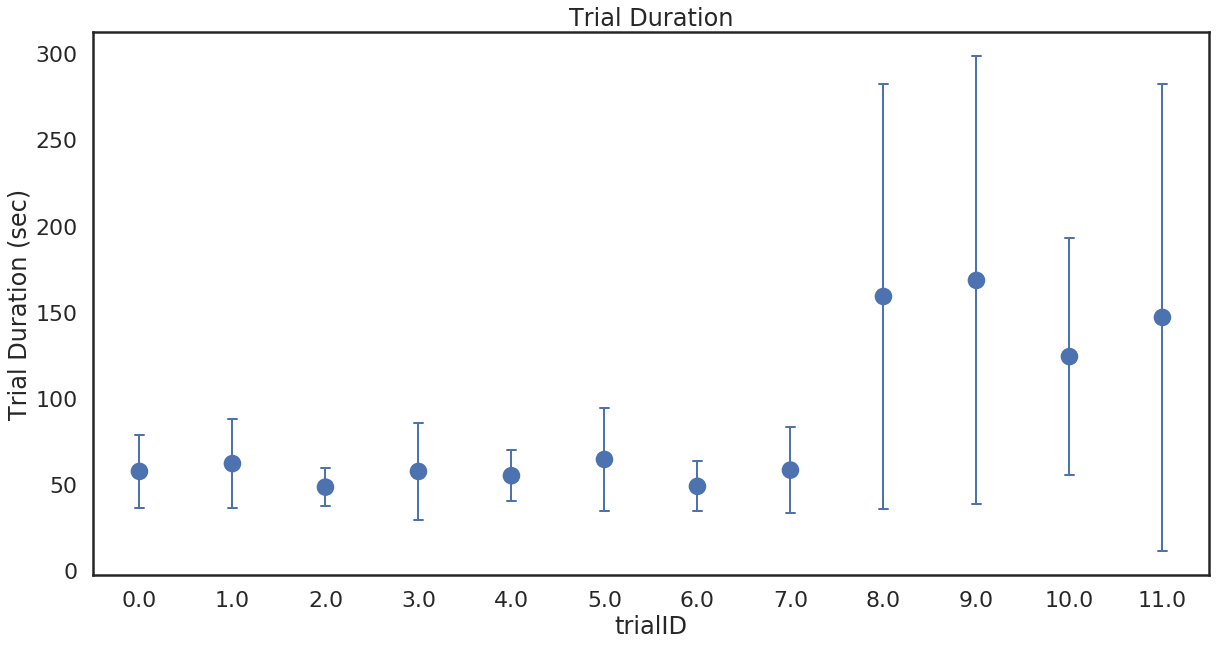

In [174]:
tmpdf = (
    samples_df
    .set_index('timestamp')
    .groupby(['subjectID','subjectfileName','trialID', 'trialNum'])
    .apply(lambda x: x.index[-1] - x.index[0])
    .rename('TrialDuration')
    .reset_index()
)
display(tmpdf)
sns.set(context = "poster", style="white", palette="deep", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
_, ax = plt.subplots(1,1,figsize=(20,10))
sns.pointplot(data=tmpdf, x='trialID', y='TrialDuration', color='b',
              errwidth=2, capsize=0.1, saturation=0.5,ci='sd', join=False)
# ax.set_ylim(60,120)
# plt.xticks(rotation=90, fontsize=15)
plt.ylabel('Trial Duration (sec)')
plt.title('Trial Duration')
plt.savefig(PLOT_PATH+'/TrialDuration.png', quality=90)

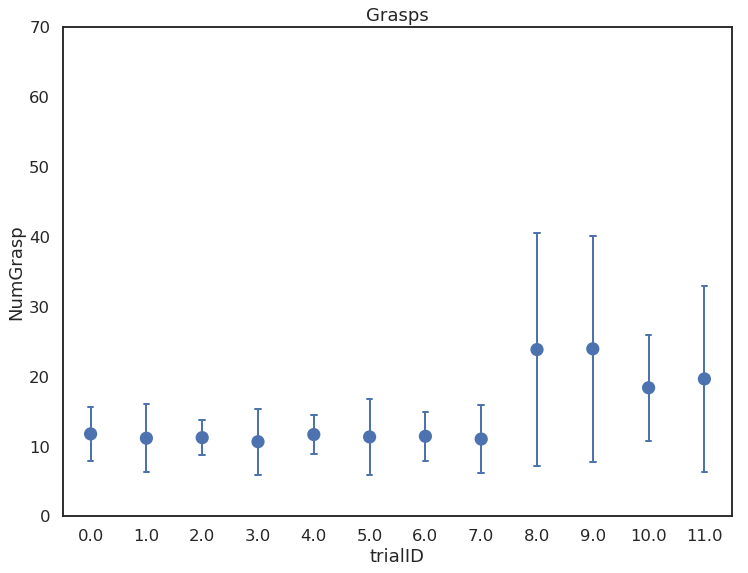

In [20]:
tmpdf = (samples_df
 .query('timestamp == grasp_onset and grasp_duration !=0 ')
 .groupby(['subjectID','subjectfileName','trialNum','trialID'], as_index=False)
 .grasp_onset
 .count()
 .rename(columns = {'grasp_onset':'NumGrasp'})
)

_, ax = plt.subplots(1,1,figsize=(12,9))
sns.pointplot(data=tmpdf, x='trialID', y='NumGrasp', color='b',
              errwidth=2, capsize=0.1, saturation=0.5, ci='sd', join=False)
ax.set_ylim(0,70)
# plt.xticks(rotation=90, fontsize=15)
plt.title('Grasps')
plt.savefig(PLOT_PATH+'/grasps.png', quality=90)

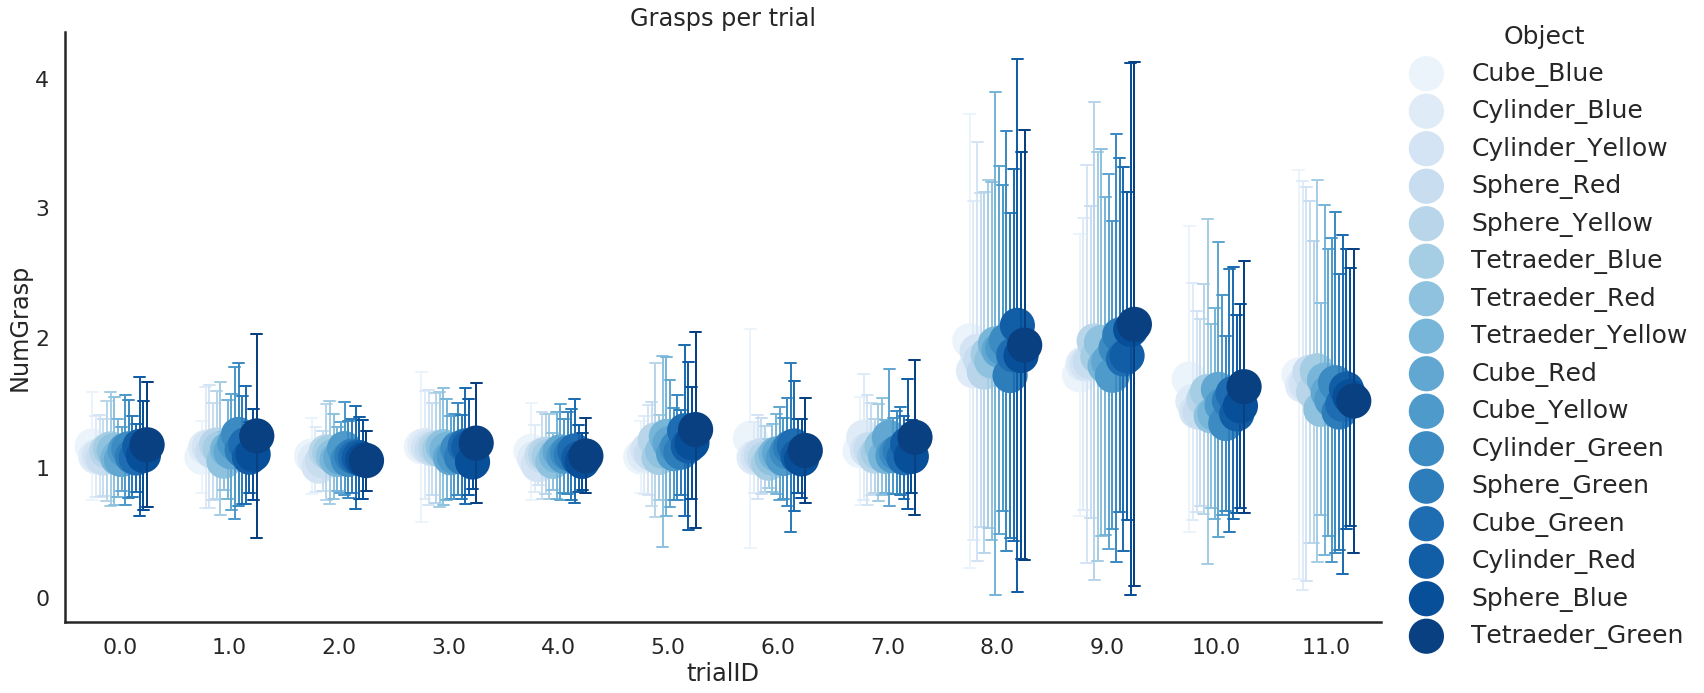

In [81]:
tmpdf = (samples_df
 .query('timestamp == grasp_onset and grasp_duration !=0 ')
 .groupby(['subjectID','trialID', 'subjectfileName','trialNum','handData_graspedObject'], as_index=False)
 .grasp_onset
 .count()
 .rename(columns = {'grasp_onset':'NumGrasp'})
)

sns.set(context = "poster", style="white", palette="deep", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
g = (
    sns.catplot(
        x='trialID', y='NumGrasp', data=tmpdf, hue ='handData_graspedObject', 
                  kind='point',scale = 2,palette='Blues',
                  errwidth=2, capsize=0.1,
                  ci='sd',  dodge=0.5, join=False,
        height = 10, aspect = 2, legend_out=False, legend=False
        
    )
)
# g.set(ylabel='Fixation Durations (sec)', ylim=(0.1,0.5), yticks=[0.1, 0.2, 0.3, 0.4, 0.5])
plt.legend(title = 'Object',loc='upper right', frameon=False, bbox_to_anchor=(1.25, 1.05), fontsize=25)
plt.title('Grasps per trial')
plt.savefig(PLOT_PATH+'/grasps_pertrial.png', transparent=True, bbox_inches='tight', quality=90)

In [69]:
tmpdf.NumGrasp.describe()

count    15357.000000
mean         1.341603
std          0.924189
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: NumGrasp, dtype: float64

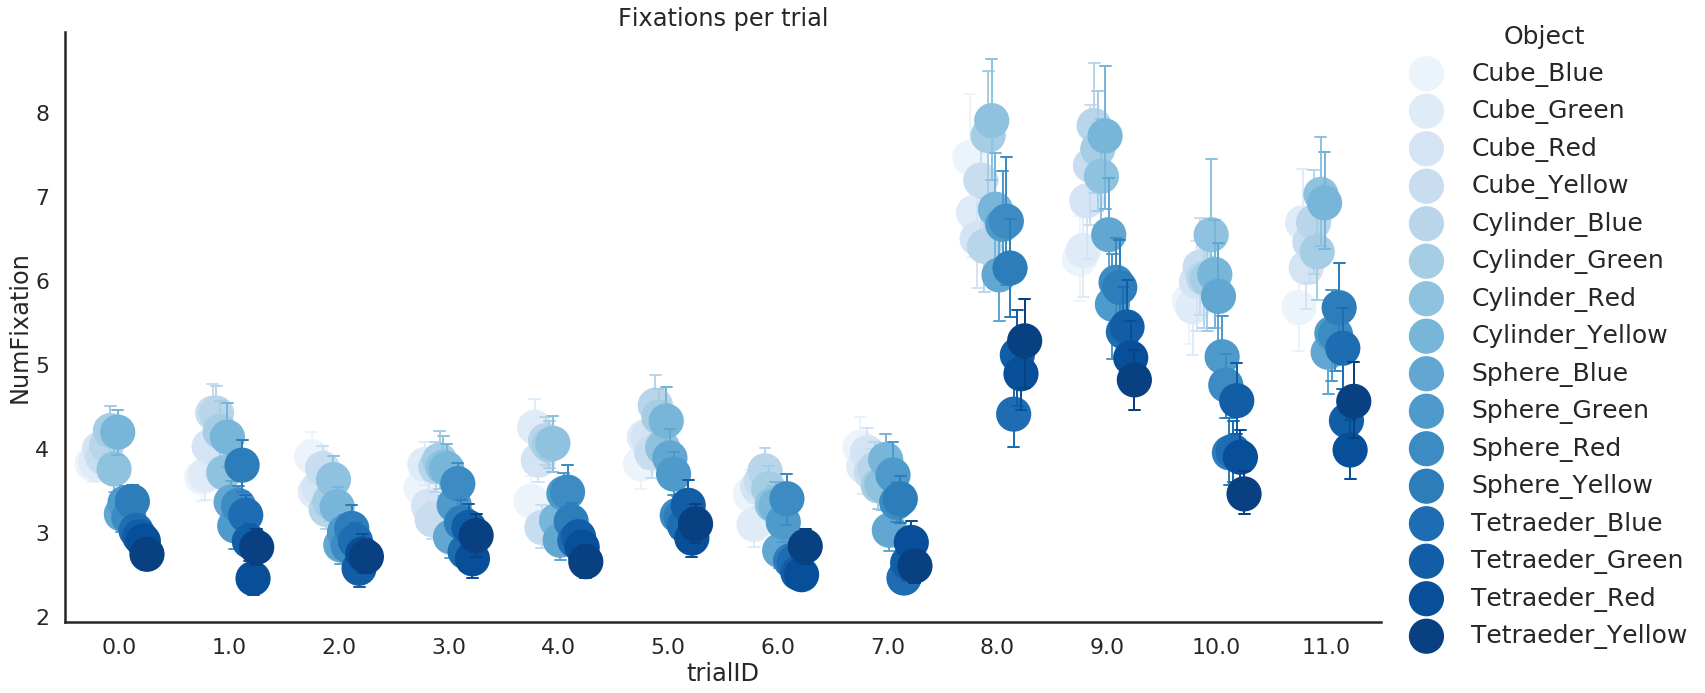

In [82]:
tmpdf = (samples_df
 .drop_duplicates(subset=['fix_duration'], keep='first')
 .query('isFixV == 1 and fix_duration !=0 and combinedEye_raycastHitObject != "Other"')
 .groupby(['subjectID','trialID','subjectfileName','trialNum','combinedEye_raycastHitObject'], as_index=False)
 .timestamp
 .count()
 .rename(columns = {'timestamp':'NumFixation'})
)

# _, ax = plt.subplots(1,1,figsize=(12,9))
# sns.pointplot(data=tmpdf, x='trialID', y='NumSamples', hue='combinedEye_raycastHitObject',palette='deep',
#               errwidth=2, capsize=0.1, saturation=0.5, ci=68, join=False, dodge=True, legend_out=True)
sns.set(context = "poster", style="white", palette="deep", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
g = (
    sns.catplot(
        x='trialID', y='NumFixation', data=tmpdf, hue ='combinedEye_raycastHitObject', 
                  kind='point',scale = 2,palette='Blues',
                  errwidth=2, capsize=0.1,
                  ci=68,  dodge=0.5, join=False,
        height = 10, aspect = 2, legend_out=False, legend=False
        
    )
)
# g.set(ylabel='Relative Frequency', xlabel='Alignment Type', ylim = (0,1))
plt.legend(title = 'Object',loc='upper right', frameon=False, bbox_to_anchor=(1.25, 1.05), fontsize=25)
plt.title('Fixations per trial')
plt.savefig(PLOT_PATH+'/fixationspertrial.png', transparent=True, bbox_inches='tight', quality=90)

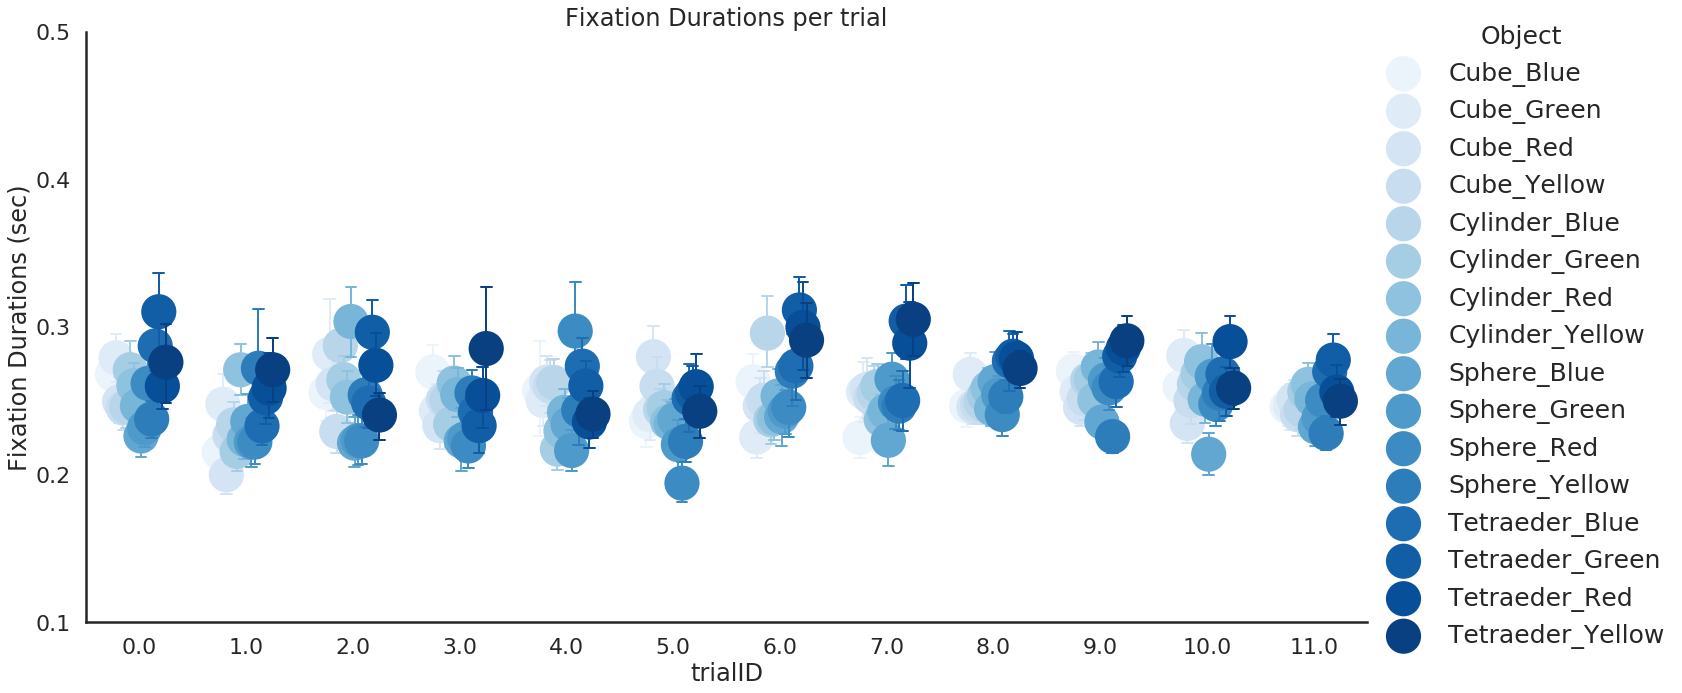

In [83]:
tmpdf = (samples_df
 .drop_duplicates(subset=['fix_duration'], keep='first')
 .query('isFixV == 1 and fix_duration !=0 and combinedEye_raycastHitObject != "Other"')
 .groupby(['subjectID','trialID','subjectfileName','trialNum','combinedEye_raycastHitObject'], as_index=False)
 .fix_duration
 .mean()
 .rename(columns = {'fix_duration':'FixationDuration'})
)

# _, ax = plt.subplots(1,1,figsize=(12,9))
# sns.pointplot(data=tmpdf, x='trialID', y='NumSamples', hue='combinedEye_raycastHitObject',palette='deep',
#               errwidth=2, capsize=0.1, saturation=0.5, ci=68, join=False, dodge=True, legend_out=True)
sns.set(context = "poster", style="white", palette="deep", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
g = (
    sns.catplot(
        x='trialID', y='FixationDuration', data=tmpdf, hue ='combinedEye_raycastHitObject', 
                  kind='point',scale = 2,palette='Blues',
                  errwidth=2, capsize=0.1,
                  ci=68,  dodge=0.5, join=False,
        height = 10, aspect = 2, legend_out=False, legend=False
        
    )
)
g.set(ylabel='Fixation Durations (sec)', ylim=(0.1,0.5), yticks=[0.1, 0.2, 0.3, 0.4, 0.5])
plt.legend(title = 'Object',loc='upper right', frameon=False, bbox_to_anchor=(1.25, 1.05), fontsize=25)
plt.title('Fixation Durations per trial')
plt.savefig(PLOT_PATH+'/fixdur_pertrial.png', transparent=True, bbox_inches='tight', quality=90)

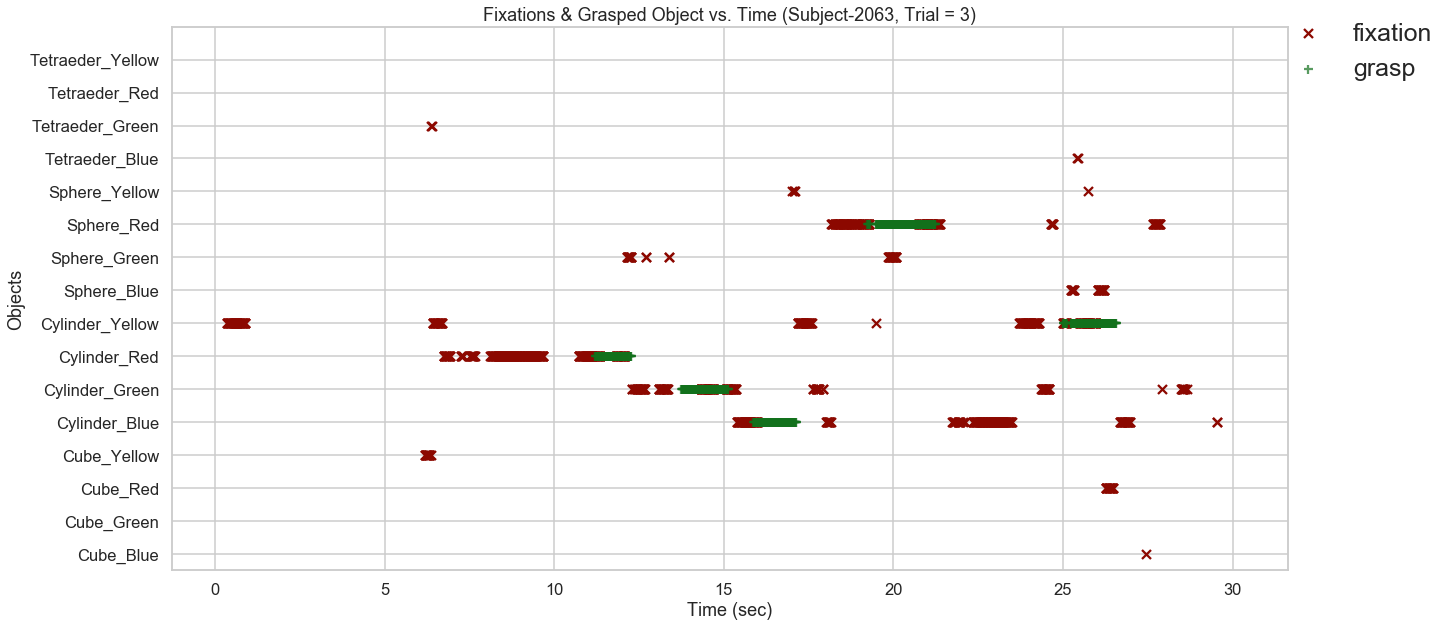

In [162]:
subject=2063
trial=3
tmpdf = (
    samples_df
    .rename(columns={'combinedEye_raycastHitObject':'eyeHit', 'handData_graspedObject':'grasp',\
                     'nosePointer_raycastHitObject':'head' })
    .query('subjectID == @subject & trialNum == @trial')
#     .query('eyeHit != "Other"')
    .query('timestamp<=30')
#     .sort_values('timestamp')
    [['timestamp', 'eyeHit', 'grasp']]
    .set_index('timestamp')
)
sns.set(context = "talk", style="whitegrid", palette="dark", font_scale=1, rc={'figure.figsize':(11.7,8.27)})
_, ax = plt.subplots(figsize=(20,10))
tmpdf['eyeHit'] = tmpdf['eyeHit'].map(objs_dict)
tmpdf['grasp'] = tmpdf['grasp'].map(objs_dict)
# tmpdf['head'] = tmpdf['head'].map(objs_dict)
ax.scatter(tmpdf.index, tmpdf['eyeHit'],color = 'r', alpha=1, label='fixation', marker='x')
ax.scatter(tmpdf.index, tmpdf['grasp'],color = 'g', alpha=0.7, label='grasp', marker='+')
# ax.scatter(tmpdf.index, tmpdf['head'],color = 'b', alpha=0.3, label='head', marker='o')

ax.set_yticks(np.arange(1, 17))
ax.set_ylim(0.5,17)
ax.set_yticklabels([obj for obj in objs_dict.keys() if obj != "Other" ])
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Objects')
ax.legend(loc='upper right', frameon=False, bbox_to_anchor=(1.15, 1.05), fontsize=25)
ax.set_title(f'Fixations & Grasped Object vs. Time (Subject-{subject}, Trial = {trial})')
plt.savefig(f'{PLOT_PATH}/eye_grasp_{subject}_{trial}.png', transparent=True, bbox_inches='tight', quality=90)

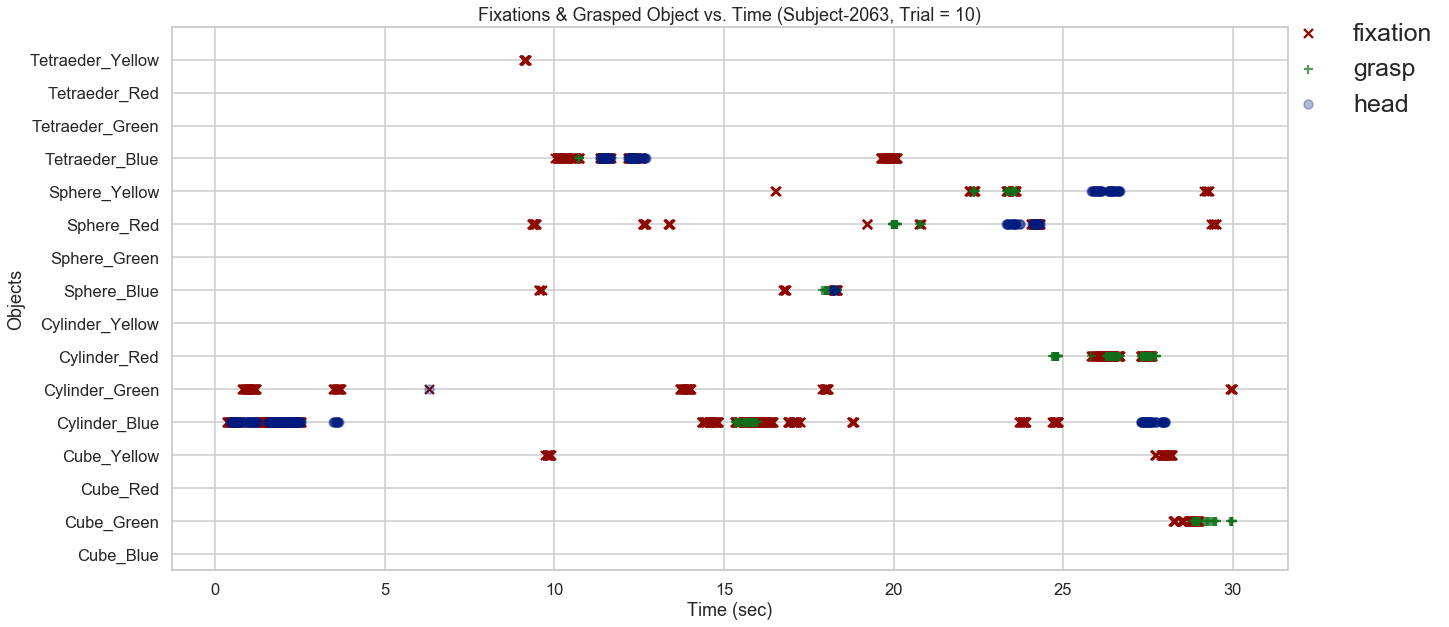

In [120]:
subject=2063
trial=10
tmpdf = (
    samples_df
    .rename(columns={'combinedEye_raycastHitObject':'eyeHit', 'handData_graspedObject':'grasp',\
                     'nosePointer_raycastHitObject':'head' })
    .query('subjectID == @subject & trialNum == @trial and isFixV==1')
    .query('eyeHit != "Other"')
    .query('timestamp<=30')

#     .sort_values('timestamp')
    [['timestamp', 'eyeHit', 'grasp', 'head', 'grasp_onset']]
    .set_index('timestamp')
)
sns.set(context = "talk", style="whitegrid", palette="dark", font_scale=1, rc={'figure.figsize':(11.7,8.27)})
_, ax = plt.subplots(figsize=(20,10))
tmpdf['eyeHit'] = tmpdf['eyeHit'].map(objs_dict)
tmpdf['grasp'] = tmpdf['grasp'].map(objs_dict)
tmpdf['head'] = tmpdf['head'].map(objs_dict)
ax.scatter(tmpdf.index, tmpdf['eyeHit'],color = 'r', alpha=1, label='fixation', marker='x')
ax.scatter(tmpdf.index, tmpdf['grasp'],color = 'g', alpha=0.7, label='grasp', marker='+')
ax.scatter(tmpdf.index, tmpdf['head'],color = 'b', alpha=0.3, label='head', marker='o')

# tmpdf['eyeHit'].plot(ax=ax, label='eyeHits', yticks=np.arange(17),color = COLORS['r'], alpha=0.5)
# tmpdf['grasp'].plot(ax=ax, label='grasp', color = COLORS['g'], linestyle=':')
ax.set_yticks(np.arange(1, 17))
ax.set_ylim(0.5,17)
ax.set_yticklabels([obj for obj in objs_dict.keys() if obj != "Other" ])
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Objects')
ax.legend(loc='upper right', frameon=False, bbox_to_anchor=(1.15, 1.05), fontsize=25)
ax.set_title(f'Fixations & Grasped Object vs. Time (Subject-{subject}, Trial = {trial})')
plt.savefig(f'{PLOT_PATH}/head_eye_grasp_{subject}_{trial}.png', transparent=True, bbox_inches='tight', quality=90)

In [130]:
samples_df['grasp_onset_bool'] = 0
idx = samples_df.query('timestamp == grasp_onset and grasp_duration !=0').index
samples_df.loc[idx, 'grasp_onset_bool'] = 1

In [137]:
samples_df['hand_theta_h'] = np.arctan2(samples_df['handData_transform_rotation_x'], samples_df['handData_transform_rotation_z'])
samples_df['hand_theta_v'] = np.arctan2(samples_df['handData_transform_rotation_y'], samples_df['handData_transform_rotation_z'])
samples_df['hand_angle'] =np.sqrt(samples_df.hand_theta_h**2 + samples_df.hand_theta_v**2)

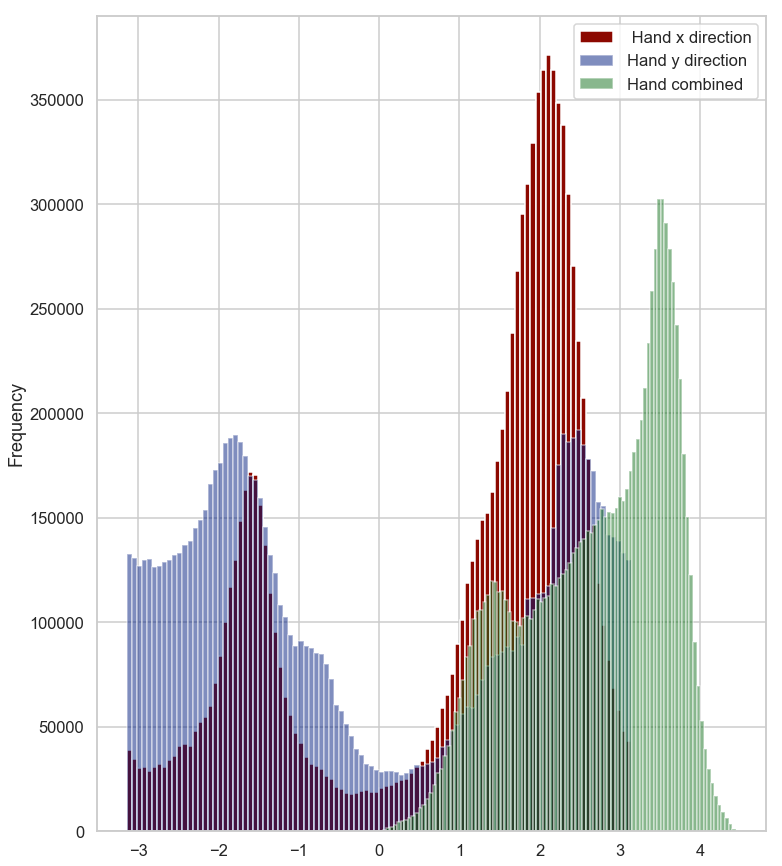

In [139]:
_, ax = plt.subplots(1,1,figsize=(12,15), sharey=True)

(samples_df
.hand_theta_h
.plot
.hist(bins=100, color='r', ax=ax, label=' Hand x direction', legend=True)
)
(samples_df
.hand_theta_v
.plot
.hist(bins=100, color='b', ax=ax, label='Hand y direction', legend=True, alpha=0.5)
)
(samples_df
.hand_angle
.plot
.hist(bins=100, color='g', ax=ax, label='Hand combined', legend=True, alpha=0.5)
)
# ax.set(xlim=(-5000, 5000), xlabel = 'Angular Acceleration in $^\circ$/sec$^2$')
# plt.savefig(f'{PLOT_PATH}/hand_theta_hist.png', transparent=True, bbox_inches='tight', quality=90)

In [140]:
samples_df['head_angle'] =np.sqrt(samples_df.head_theta_h**2 + samples_df.head_theta_v**2)
samples_df['eye_angle'] =np.sqrt(samples_df.combined_eye_theta_h**2 + samples_df.combined_eye_theta_v**2)

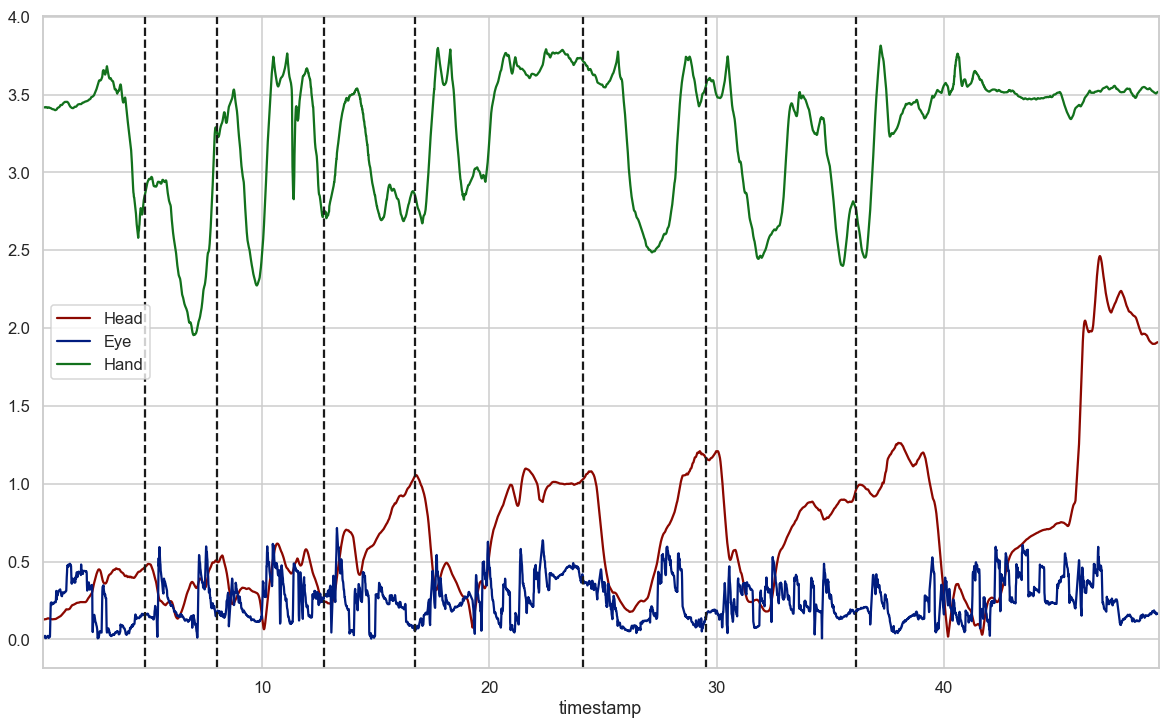

In [146]:
subject = 2018
trial = 6
_, ax = plt.subplots(figsize=(20, 12))

(samples_df
 .query('subjectID == @subject and trialNum==@trial')
 .plot('timestamp', 'head_angle', kind='line', ax=ax, label='Head', color='r', legend=True)
)
(samples_df
 .query('subjectID == @subject and trialNum==@trial')
 .plot('timestamp', 'eye_angle', kind='line', ax=ax, label='Eye', color='b', legend=True)
)
(samples_df
 .query('subjectID == @subject and trialNum==@trial')
 .plot('timestamp', 'hand_angle', kind='line', ax=ax, label='Hand', color='g', legend=True)
)
tmpdf = samples_df.query('subjectID == @subject and trialNum==@trial')
for i, val in tmpdf.iterrows():
#     print(val)
    if val.grasp_onset_bool == True:
        plt.axvline(val.timestamp, color='k', ls='--')


In [147]:
samples_df['hand_angular_vel'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .hand_angle
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))

c:\users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


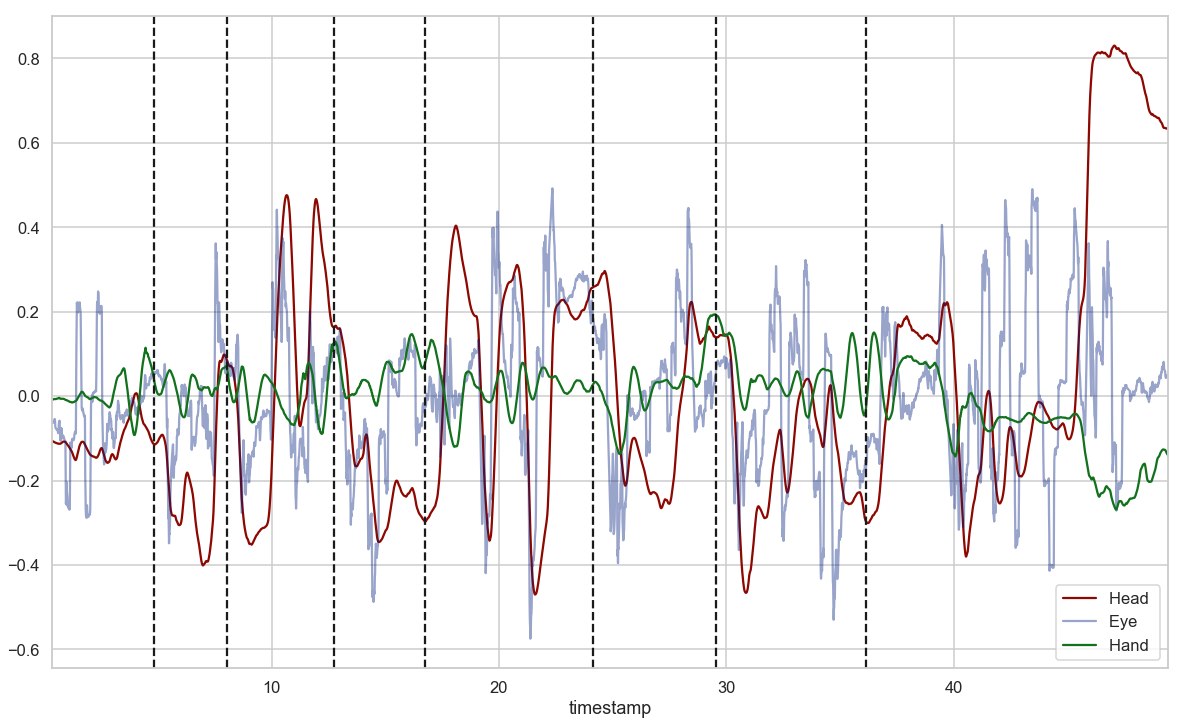

In [166]:
_, ax = plt.subplots(figsize=(20, 12))

subject = 2018
trial = 6
tmpdf = samples_df.query('subjectID == @subject and trialNum==@trial')
tmpdf.nosePointer_direction_x = tmpdf.nosePointer_direction_x - tmpdf.nosePointer_direction_x.mean()
tmpdf.combinedEye_direction_x = tmpdf.combinedEye_direction_x - tmpdf.combinedEye_direction_x.mean()
tmpdf.handData_transform_rotation_x = tmpdf.handData_transform_rotation_x - tmpdf.handData_transform_rotation_x.mean()
(tmpdf
 .plot('timestamp', 'nosePointer_direction_x', kind='line', ax=ax, label='Head ', color='r', legend=True)
)
(tmpdf
 .plot('timestamp', 'combinedEye_direction_x', kind='line', ax=ax, label='Eye  ', color='b', alpha=0.4, legend=True)
)
(tmpdf
 .plot('timestamp', 'handData_transform_rotation_x', kind='line', ax=ax, label='Hand ', color='g', legend=True)
)

for i, val in tmpdf.iterrows():
#     print(val)
    if val.grasp_onset_bool == True:
        plt.axvline(val.timestamp, color='k', ls='--')

# ax.set_xlabel('timestamp')

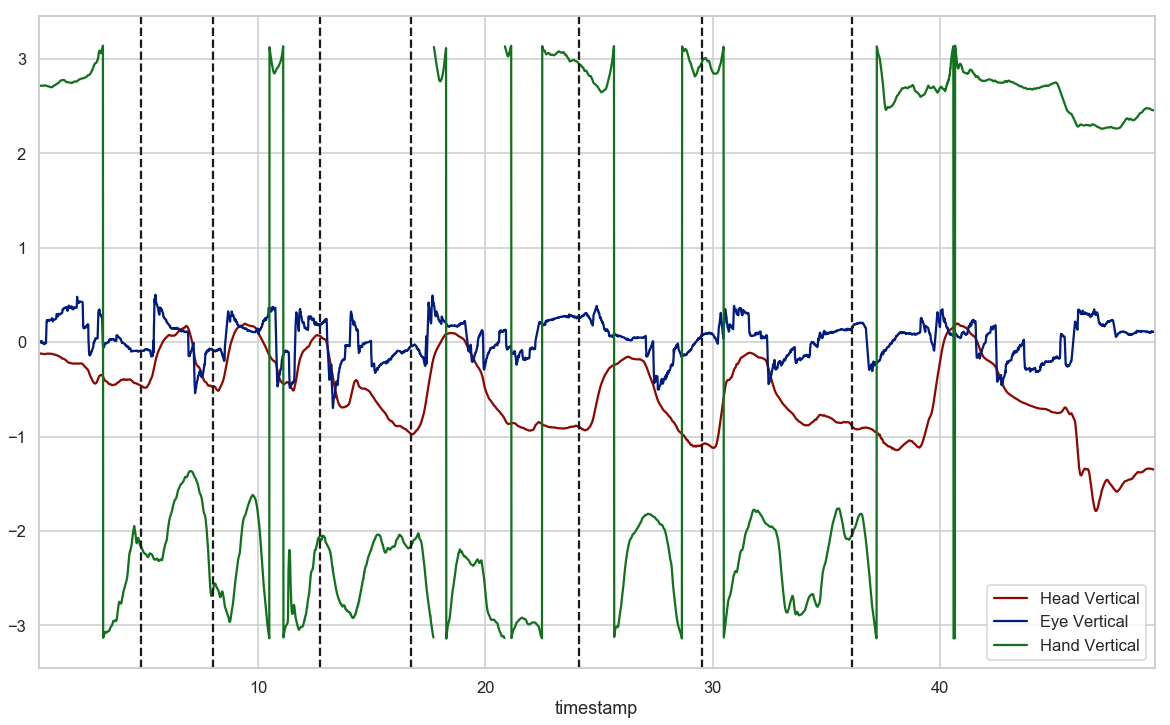

In [152]:
_, ax = plt.subplots(figsize=(20, 12))

subject = 2018
trial = 6
tmpdf = samples_df.query('subjectID == @subject and trialNum==@trial')
(tmpdf
 .plot('timestamp', 'head_theta_v', kind='line', ax=ax, label='Head Vertical', color='r', legend=True)
)
(tmpdf
 .plot('timestamp', 'combined_eye_theta_v', kind='line', ax=ax, label='Eye Vertical ', color='b', legend=True)
)
(tmpdf
 .plot('timestamp', 'hand_theta_v', kind='line', ax=ax, label='Hand Vertical', color='g', legend=True)
)

for i, val in tmpdf.iterrows():
#     print(val)
    if val.grasp_onset_bool == True:
        plt.axvline(val.timestamp, color='k', ls='--')

# ax.set_xlabel('timestamp')

In [132]:
samples_df.columns

Index(['timestamp', 'leftEye_position_x', 'leftEye_position_y',
       'leftEye_position_z', 'leftEye_direction_x', 'leftEye_direction_y',
       'leftEye_direction_z', 'leftEye_raycastHitObject',
       'leftEye_raycastHitLocation_x', 'leftEye_raycastHitLocation_y',
       'leftEye_raycastHitLocation_z', 'rightEye_position_x',
       'rightEye_position_y', 'rightEye_position_z', 'rightEye_direction_x',
       'rightEye_direction_y', 'rightEye_direction_z',
       'rightEye_raycastHitObject', 'rightEye_raycastHitLocation_x',
       'rightEye_raycastHitLocation_y', 'rightEye_raycastHitLocation_z',
       'combinedEye_position_x', 'combinedEye_position_y',
       'combinedEye_position_z', 'combinedEye_direction_x',
       'combinedEye_direction_y', 'combinedEye_direction_z',
       'combinedEye_raycastHitObject', 'combinedEye_raycastHitLocation_x',
       'combinedEye_raycastHitLocation_y', 'combinedEye_raycastHitLocation_z',
       'nosePointer_position_x', 'nosePointer_position_y',
   

In [54]:
tmpdf.loc[tmpdf.NumFixation.idxmax(), :]

subjectID                                                          2007
trialID                                                               8
subjectfileName                 ../experiment_et_data\subject2007_2.etd
trialNum                                                             19
combinedEye_raycastHitObject                                Cube_Yellow
NumFixation                                                          69
Name: 621, dtype: object

In [21]:
samples_df.handData_graspedObject.unique()

array([nan, 'Cube_Blue', 'Sphere_Red', 'Tetraeder_Blue',
       'Tetraeder_Yellow', 'Tetraeder_Red', 'Cylinder_Yellow',
       'Sphere_Yellow', 'Cylinder_Blue', 'Tetraeder_Green', 'Cube_Green',
       'Cylinder_Red', 'Cube_Red', 'Cylinder_Green', 'Sphere_Green',
       'Sphere_Blue', 'Cube_Yellow'], dtype=object)